In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# creating a PyTorch device (device) based on whether a Compute Unified Device Architecture(CUDA)-compatible GPU is available or not. This is a common practice to automatically select the appropriate device for tensor computations.
# torch.cuda.is_available(): Checks if a CUDA-compatible GPU is available. If it returns True, it means you can use GPU acceleration; otherwise, it returns False.
# torch.device("cuda" if torch.cuda.is_available() else "cpu"): Creates a PyTorch device object based on the availability of a GPU. If a GPU is available, it sets the device to "cuda"; otherwise, it sets it to "cpu".
print("Selected device:", device)

# If a GPU is available, additional configurations can be done here
if device.type == "cuda":
    # Set the device index (you can choose the GPU index if multiple GPUs are available)
    gpu_index = torch.cuda.current_device()
    print(f"Using GPU: {torch.cuda.get_device_name(gpu_index)}")

    # Additional GPU-related configurations can be done here if needed
else:
    print("Using CPU.")

Selected device: cuda
Using GPU: NVIDIA GeForce RTX 4090


In [2]:
!pip install scikeras
!pip install typeguard
!pip install efficientnet


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

from keras.layers import InputLayer, Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer

2024-07-08 03:55:22.919928: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 03:55:22.948164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
import os
# Specify the path to your zip file on Google Drive
zip_file_path = 'Final_Dataset.zip'

# Unzip the file with overwrite option
!unzip -o "{zip_file_path}"

# Get the directory name after unzipping (assuming it matches the zip filename without extension)
unzipped_dir_name = os.path.splitext(os.path.basename(zip_file_path))[0]

print(f"Directory unzipped (overwriting existing files): {unzipped_dir_name}")

Archive:  Final_Dataset.zip
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1001.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1002.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1003.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1004.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1005.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1006.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1007.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1008.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1009.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1010.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1011.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1012.jpeg  
  inflating: Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1013.jpeg  
  inflatin

In [7]:
parent_path= "Final_Dataset/VGG16_Dataset/"

img_height= 224
img_width = 224


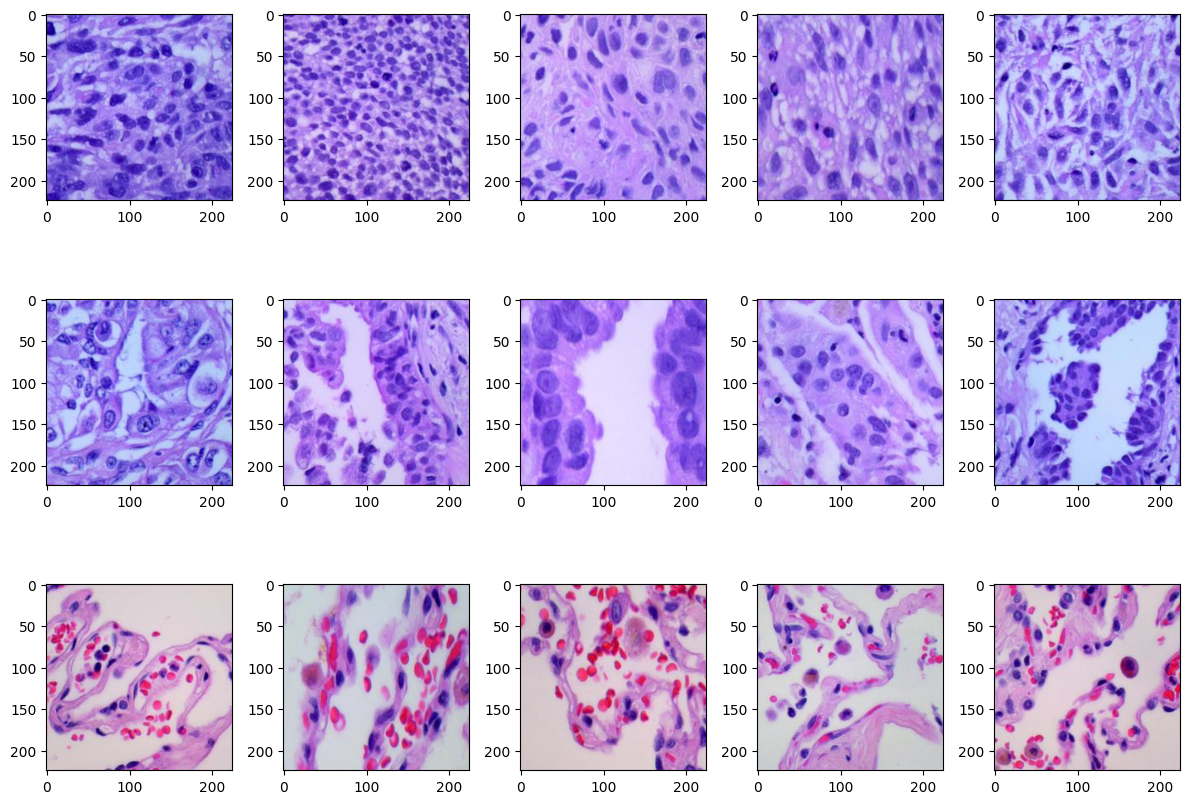

In [8]:
pic_size = 224

# input path for the images
base_path = parent_path

plt.figure(0, figsize=(12,20))
cpt = 0

for cancertype in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + cancertype + "/" +os.listdir(base_path + "train/" + cancertype)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [9]:
# count number of train images for each cancertype

print("Count number of train images")
for cancertype in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + cancertype))) + " " + cancertype + " images")

print("Count number of test images")
for cancertype in os.listdir(base_path + "test"):
    print(str(len(os.listdir(base_path + "test/" + cancertype))) + " " + cancertype + " images")

print("Count number of validate images")
for cancertype in os.listdir(base_path + "valid"):
    print(str(len(os.listdir(base_path + "valid/" + cancertype))) + " " + cancertype + " images")

Count number of train images
3500 lung_scc images
3500 lung_aca images
3500 lung_n images
Count number of test images
1000 lung_scc images
1000 lung_aca images
1000 lung_n images
Count number of validate images
500 lung_scc images
500 lung_aca images
500 lung_n images


In [10]:
# Create instances of ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
datagen_test = ImageDataGenerator(rescale=1./255)
datagen_valid = ImageDataGenerator(rescale=1./255)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
epochs = 100

# datagen_train = ImageDataGenerator()
# datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(base_path + "train",
                                               target_size=(pic_size, pic_size),
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True)


test_set = datagen_test.flow_from_directory(base_path + "test",
                                            target_size=(pic_size, pic_size),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

valid_dataset = datagen_valid.flow_from_directory(os.path.join(base_path, "valid"),
                                                 target_size=(pic_size, pic_size),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 10500 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [12]:
# number of possible label values
num_classes = train_set.num_classes

class EfficientNetBase(Layer):
    def __init__(self, input_shape):
        super(EfficientNetBase, self).__init__()
        self.EfficientNet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    def call(self, inputs):
        return self.EfficientNet(inputs)

def EfficientNet_model(input_shape=(224, 224, 3), num_classes=3):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # Add the EfficientNet base model
    EfficientNet_base = EfficientNetBase(input_shape)(inputs)

    # Add custom layers on top of the base model
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv1')(EfficientNet_base)
    x = MaxPooling2D((2, 2), name='maxpool1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(1024, activation='relu', name='dense1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(512, activation='relu', name='dense2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

    # Define the final model
    model = Model(inputs=inputs, outputs=predictions)

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
model_EfficientNet = EfficientNet_model(input_shape=(224, 224, 3), num_classes=num_classes)
model_EfficientNet.summary()

2024-07-08 03:55:28.657119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 03:55:28.658559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 03:55:28.658582: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 03:55:28.660606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 03:55:28.660630: I external/local_xla/xla/stream_executor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_base              │ (None, 7, 7, 1280)     │     4,049,571 │
│ (EfficientNetBase)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 7, 7, 512)      │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,359,782 (50.96 MB)

 Trainable params: 13,317,759 (50.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [17]:
def f1_score(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    return f1_val

In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [19]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(verbose=1, patience=3)

In [20]:
model_EfficientNet.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [21]:
%time
history=model_EfficientNet.fit(train_set,validation_data=valid_dataset,epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 μs
Wall time: 6.2 μs
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720410959.362447    1751 service.cc:145] XLA service 0x7f23d0005740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720410959.362759    1751 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-08 03:55:59.982918: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 03:56:01.741609: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1720410968.881

118/329 ━━━━━━━━━━━━━━━━━━━━ 31s 149ms/step - accuracy: 0.8402 - auc: 0.8802 - f1_score: 0.7420 - loss: 0.8666 - precision: 0.7729 - recall: 0.7247

I0000 00:00:1720411019.943470    1984 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_20911', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1720411041.191526    1750 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 196 bytes spill stores, 196 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 36 bytes spill stores, 36 bytes spill loads



328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9002 - auc: 0.9411 - f1_score: 0.8416 - loss: 0.5217 - precision: 0.8624 - recall: 0.8281

I0000 00:00:1720411074.200122    2164 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2137', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1720411077.064970    2241 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2137', 260 bytes spill stores, 260 bytes spill loads



329/329 ━━━━━━━━━━━━━━━━━━━━ 139s 273ms/step - accuracy: 0.9004 - auc: 0.9413 - f1_score: 0.8420 - loss: 0.5202 - precision: 0.8628 - recall: 0.8286 - val_accuracy: 0.5904 - val_auc: 0.5287 - val_f1_score: 0.3063 - val_loss: 1.4512 - val_precision: 0.3515 - val_recall: 0.2707 - learning_rate: 0.0010
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 50s 150ms/step - accuracy: 0.9634 - auc: 0.9904 - f1_score: 0.9431 - loss: 0.1947 - precision: 0.9549 - recall: 0.9342 - val_accuracy: 0.6838 - val_auc: 0.6464 - val_f1_score: 0.5243 - val_loss: 7.8027 - val_precision: 0.5258 - val_recall: 0.5227 - learning_rate: 0.0010
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - accuracy: 0.9759 - auc: 0.9954 - f1_score: 0.9635 - loss: 0.1120 - precision: 0.9693 - recall: 0.9581 - val_accuracy: 0.8091 - val_auc: 0.8719 - val_f1_score: 0.7119 - val_loss: 1.4342 - val_precision: 0.7161 - val_recall: 0.7080 - learning_rate: 0.0010
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 52s 154ms/step - accuracy: 0.9280 - a

In [30]:
# Save the entire model to a HDF5 file.
model_EfficientNet.save('outputs/model_EfficientNet.h5')  # Save the entire model

In [31]:
import json

# Convert the history.history dict to JSON
history_dict = history.history
json.dump(history_dict, open('outputs/history.json', 'w'))

In [32]:
print(history.history.keys())

dict_keys(['accuracy', 'auc', 'f1_score', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_f1_score', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


In [33]:
model_EfficientNet.evaluate(test_set, verbose=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9627 - auc: 0.9942 - f1_score: 0.9439 - loss: 0.1287 - precision: 0.9460 - recall: 0.9417


[0.06335701793432236,
 0.9814444780349731,
 0.9729549288749695,
 0.9713333249092102,
 0.9986380934715271,
 0.9721955060958862]

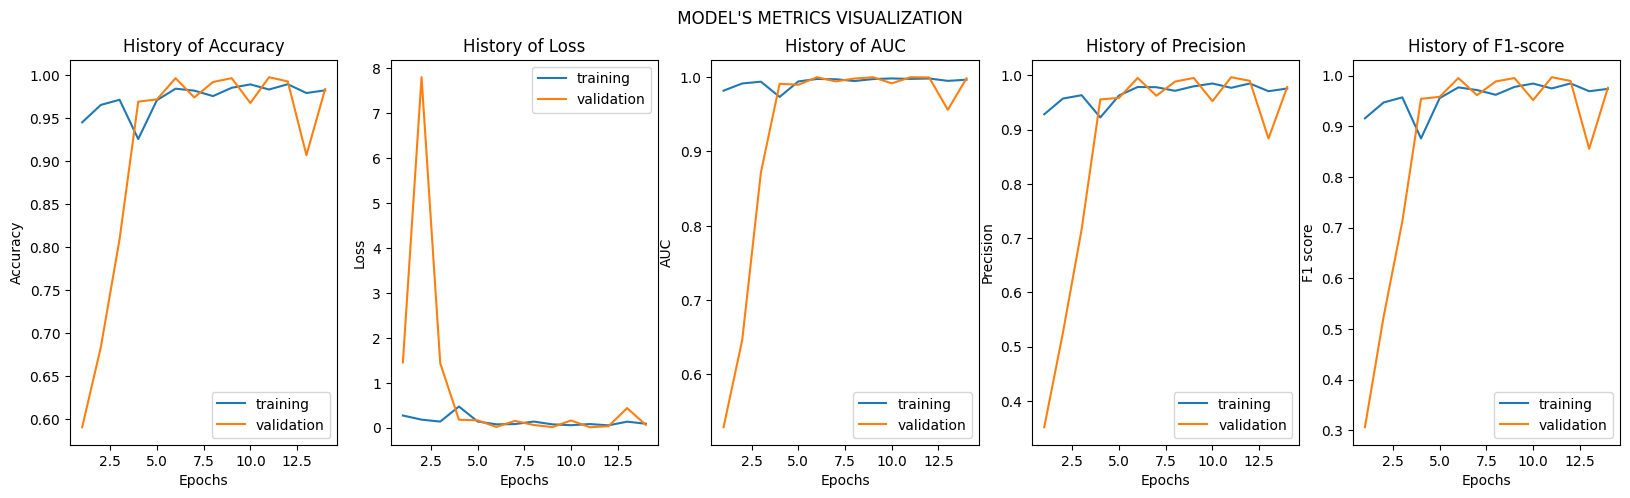

In [34]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
)


In [35]:
result = model_EfficientNet.evaluate(valid_dataset,batch_size=32)
print("test_loss, test accuracy",result)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9839 - auc: 0.9978 - f1_score: 0.9757 - loss: 0.0699 - precision: 0.9788 - recall: 0.9726
test_loss, test accuracy [0.06275799870491028, 0.9840000867843628, 0.9785522818565369, 0.9733333587646484, 0.9984197616577148, 0.9758841395378113]


In [36]:
label_dict={0:'adenocarcinoma',1:'benign/non-cancerous_lung_tumor',2:'squamous_cell_carcinoma'}

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def prediction(url):
    img=plt.imread(url)
    plt.imshow(img)
    data=img_to_array(img)
    data=data/255
    data=tf.image.resize(data,(224,224))
    samples=np.expand_dims(data,0)
    samples=np.resize(samples,(1,224,224,3))
    result=model_EfficientNet.predict(samples)
    result=list(result[0])
    print(result)
    predictions=label_dict[np.argmax(result)]
    return predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[9.938017e-15, 1.0, 1.2771203e-19]


'benign/non-cancerous_lung_tumor'

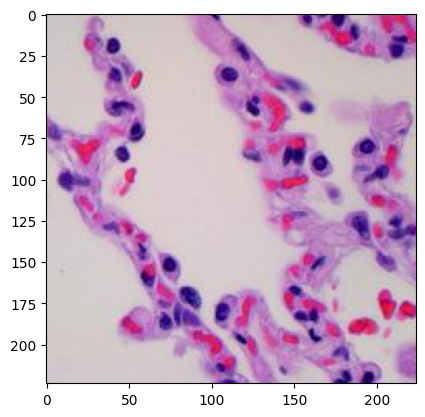

In [40]:
prediction('Final_Dataset/VGG16_Dataset/test/lung_n/lungn1012.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.9581587, 0.0014387472, 0.040402673]


'adenocarcinoma'

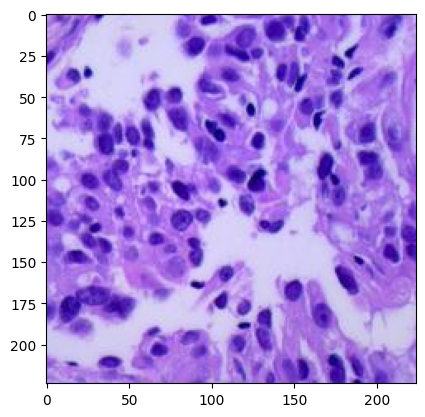

In [41]:
prediction('Final_Dataset/VGG16_Dataset/test/lung_aca/lungaca1052.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[1.140472e-09, 2.8049925e-26, 1.0]


'squamous_cell_carcinoma'

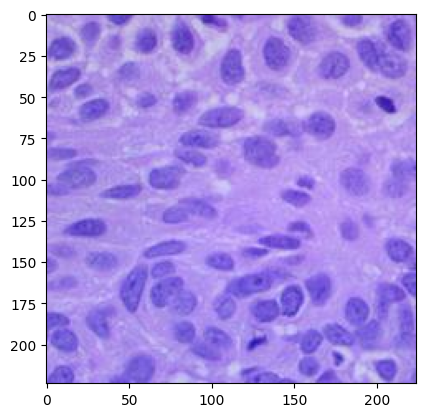

In [42]:
prediction('Final_Dataset/VGG16_Dataset/test/lung_scc/lungscc1084.jpeg')